# Altering Metropolis-Hastings

This notebook alters the Metropolis-Hastings acceptance probability by only accepting proposals if the energy is lower than the previous step. As the results show below, this drastically reduces the acceptance rate and will have the tendency to be stuck in local minima.

In [7]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=API_token
)

backend = service.backend("ibmq_qasm_simulator")
sampler = Sampler(backend=backend)

In [8]:
import numpy as np
import random
import copy
import re
import matplotlib.pyplot as plt

# Problem modelling imports
from docplex.mp.model import Model

# Qiskit imports
from qiskit.circuit import Parameter
from qiskit.circuit.library import QAOAAnsatz
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization import QuadraticProgram

from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo

from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer

from qiskit.quantum_info import Operator

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [9]:
qubo_vector = np.array([3.418, 2.0913, 6.2415, 4.4436, 10.892, 3.4051])
qubo_matrix = np.array(
    [
        [1.07978412, 0.00768914, 0.11227606, -0.06842969, -0.01016793, -0.00839765],
        [0.00768914, 0.10922887, -0.03043424, -0.0020045, 0.00670929, 0.0147937],
        [0.11227606, -0.03043424, 0.985353, 0.02307313, -0.05249785, 0.00904119],
        [-0.06842969, -0.0020045, 0.02307313, 0.6043817, 0.03740115, -0.00945322],
        [-0.01016793, 0.00670929, -0.05249785, 0.03740115, 0.79839634, 0.07616951],
        [-0.00839765, 0.0147937, 0.00904119, -0.00945322, 0.07616951, 1.08464544],
    ]
)
n=len(qubo_vector)

quadratic_program = QuadraticProgram('example')

for i in range(6):
        quadratic_program.binary_var(name = 'x_%d' %i)
        
quadratic_program.maximize(quadratic = qubo_matrix, linear = qubo_vector)
print(quadratic_program.export_as_lp_string())

qubo_converter = QuadraticProgramToQubo()
qubo = qubo_converter.convert(quadratic_program)

op, offset = qubo.to_ising()

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: example

Maximize
 obj: 3.418000000000 x_0 + 2.091300000000 x_1 + 6.241500000000 x_2
      + 4.443600000000 x_3 + 10.892000000000 x_4 + 3.405100000000 x_5 + [
      2.159568240000 x_0^2 + 0.030756560000 x_0*x_1 + 0.449104240000 x_0*x_2
      - 0.273718760000 x_0*x_3 - 0.040671720000 x_0*x_4 - 0.033590600000 x_0*x_5
      + 0.218457740000 x_1^2 - 0.121736960000 x_1*x_2 - 0.008018000000 x_1*x_3
      + 0.026837160000 x_1*x_4 + 0.059174800000 x_1*x_5 + 1.970706000000 x_2^2
      + 0.092292520000 x_2*x_3 - 0.209991400000 x_2*x_4 + 0.036164760000 x_2*x_5
      + 1.208763400000 x_3^2 + 0.149604600000 x_3*x_4 - 0.037812880000 x_3*x_5
      + 1.596792680000 x_4^2 + 0.304678040000 x_4*x_5 + 2.169290880000 x_5^2 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



In [10]:
def extract_thetas(initial_state, epsilon):
    thetas = []
    for i in initial_state:
        if i <= epsilon:
            thetas.append(2 * np.arcsin(np.sqrt(epsilon)))
        elif i >= (1-epsilon):
            thetas.append(2 * np.arcsin(np.sqrt(1-epsilon)))
        else:
            thetas.append(2 * np.arcsin(np.sqrt(i)))
    return thetas

def set_init_state(thetas):
    init_qc = QuantumCircuit(len(thetas))
    for idx, theta in enumerate(thetas):
        init_qc.ry(theta, idx)
    return init_qc


In [11]:
def create_mixer_H(thetas):
    circuit = QuantumCircuit(len(thetas))
    beta = Parameter("beta")

    for index, theta in enumerate(thetas):
        circuit.ry(-theta, index)
        circuit.rz(-2.0 * beta, index)
        circuit.ry(theta, index)
    return circuit

def get_WQAOA_circuit(op, initial_state, N = 3):
    thetas = extract_thetas(initial_state, epsilon = 0.3)
    ws_mixer = create_mixer_H(thetas)
    init_qc = set_init_state(thetas)
    ansatz = QAOAAnsatz(op, reps = N, mixer_operator=ws_mixer, initial_state=init_qc)
    param = 2*np.pi*np.random.rand(ansatz.num_parameters)
    ansatz = ansatz.assign_parameters(param)
    return ansatz

def run_WQAOA(qc):
    qc.measure_all()
    qc = generate_preset_pass_manager(optimization_level=1, 
                                      basis_gates=['u', 'cx']).run(qc)
    result = sampler.run(qc).result()
    bin_dict = result.quasi_dists[0].binary_probabilities()
    return bin_dict

def proposed_state(bin_dict_result):
    most_prob_str = max(bin_dict_result, key=bin_dict_result.get)
    s_prime = [int(char) for char in most_prob_str]
    s_prime = s_prime[::-1]
    return s_prime

## Change in Metropolis-Hastings

In [12]:
def metropolis_hastings(s, s_prime, E_s, E_s_prime, T, threshold):
    delta_E = E_s_prime - E_s
    accept_prob = min(1, np.exp(delta_E / T))
    accepted = 0
    if accept_prob >= threshold and E_s_prime <= E_s:
        s = s_prime
        E_s = E_s_prime
        accepted += 1
    return s, E_s, accepted

In [ ]:
# first iteration calculate outside loop to get s & E_s

s = [random.choice([0, 1]) for _ in range(n)]
E_s = abs(qubo.objective.evaluate([int(i) for i in s]))

x = []
y = []
acc_no = 0
iter = 200

# loop starts with second iteration as Metropolis-Hastings (M-H) acceptance probability needs both s AND s_prime
for i in range(iter-1):
    
    circ = get_WQAOA_circuit(op, s)
    
    s_int = int(''.join(map(str, s)), 2)
    x.append(s_int)
    y.append(E_s)
    
    result = run_WQAOA(circ)
    
    s_prime = proposed_state(result)
    E_s_prime = abs(qubo.objective.evaluate([int(i) for i in s_prime]))
    
    accept_threshold = np.random.uniform(0, 1)
    
    T = 5
    s, E_s, accepted = metropolis_hastings(s, s_prime, E_s, E_s_prime, T, accept_threshold)
    
    acc_no = acc_no + accepted
    
accept_rate = acc_no / iter


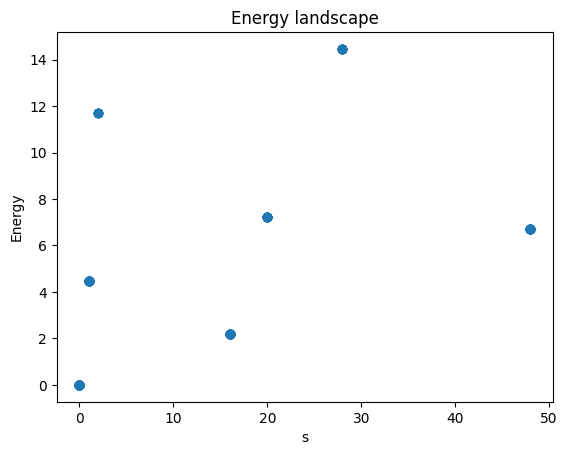

0.085


In [14]:
plt.scatter(x, y) # where i is simply the iterator
plt.xlabel("s")
plt.ylabel("Energy")
plt.title("Energy landscape")

plt.show()
print(accept_rate)

In [15]:
print("The QMCMC solution (successive convergence to) is " + str(y))

The QMCMC solution (successive convergence to) is [14.45663235, 14.45663235, 14.45663235, 14.45663235, 14.45663235, 14.45663235, 14.45663235, 14.45663235, 11.69039634, 11.69039634, 11.69039634, 11.69039634, 11.69039634, 7.244501570000001, 7.244501570000001, 7.244501570000001, 7.244501570000001, 7.244501570000001, 7.244501570000001, 7.244501570000001, 7.244501570000001, 7.244501570000001, 7.244501570000001, 7.244501570000001, 7.244501570000001, 7.244501570000001, 7.244501570000001, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 6.71369127, 4.48974544, 4.48974544, 4.48974544, 4.48974544, 4.48974544, 4.48974544, 4.48974544, 4.48974544, 4.48974544, 4.48974544, 4.48974544, 4.48974544, 4.48974544